In [1]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [2]:
import pandas as pd
train_data = pd.read_csv('c:/data/text/ratings_train.csv',encoding='ms949')
test_data = pd.read_csv('c:/data/text/ratings_test.csv',encoding='ms949')

In [3]:
len(train_data)

150000

In [4]:
train_data[:3]

,document,label
0,아 더빙.. 진짜 짜증나네요 목소리,0
1,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,너무재밓었다그래서보는것을추천한다,0


In [5]:
len(test_data)

50000

In [6]:
test_data[:3]

,document,label
0,굳 ㅋ,1
1,GDNTOPCLASSINTHECLUB,0
2,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0


In [7]:
# 중복되지 않은 데이터 확인
train_data['document'].nunique(),
train_data['label'].nunique()
# 중복값이 약 4000개

2

In [8]:
#중복값 제거
train_data.drop_duplicates(subset=['document'], inplace=True)
len(train_data)

146158

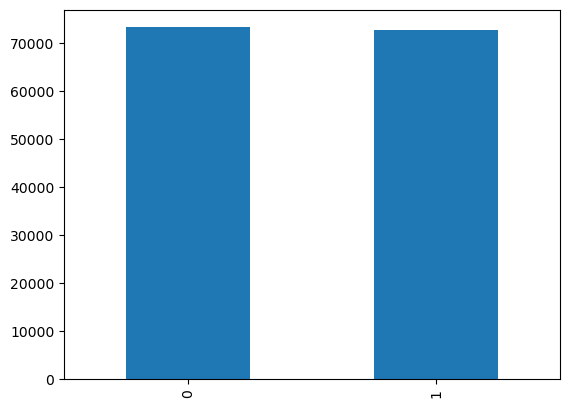

In [9]:
import matplotlib.pyplot as plt
train_data['label'].value_counts().plot(kind = 'bar')
plt.show()

In [10]:
train_data.loc[train_data.document.isnull()]

,document,label
25857,NaN,1


In [11]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
train_data.isnull().values.any()

False

In [12]:
#특수문자,기호 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data[:3]

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_5796\3567180027.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


,document,label
0,아 더빙 진짜 짜증나네요 목소리,0
1,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1
2,너무재밓었다그래서보는것을추천한다,0


In [13]:
import numpy as np
#공백 제거
train_data['document'] = train_data['document'].str.replace('^ +', "")
train_data['document'].replace('', np.nan, inplace=True)
train_data.isnull().sum()

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_5796\991819538.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', "")


document    784
label         0
dtype: int64

In [14]:
train_data.loc[train_data.document.isnull()][:3]

,document,label
404,NaN,0
412,NaN,1
470,NaN,1


In [15]:
#null 샘플 제거
train_data = train_data.dropna(how = 'any')
len(train_data)

145373

In [16]:
# test_data에도 동일한 과정 적용
test_data.drop_duplicates(subset = ['document'], inplace=True)
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['document'] = test_data['document'].str.replace('^ +', "")
test_data['document'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how='any')
len(test_data)

C:\Users\tjoeun\AppData\Local\Temp\ipykernel_5796\2044650692.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
C:\Users\tjoeun\AppData\Local\Temp\ipykernel_5796\2044650692.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  test_data['document'] = test_data['document'].str.replace('^ +', "")


48844

In [17]:
# 불용어 사전
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과',
             '도','를','으로','자','에','와','한','하다']

In [18]:
from konlpy.tag import Okt
okt = Okt()
X_train = []
#형태소 분석
#for sentence in train_data['document']:
for sentence in train_data['document'][:10000]:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [19]:
print(X_train[:3])

[['아', '더빙', '진짜', '짜증나다', '목소리'], ['흠', '포스터', '보고', '초딩', '영화', '줄', '오버', '연기', '조차', '가볍다', '않다'], ['너', '무재', '밓었', '다그', '래서', '보다', '추천', '다']]


In [20]:
# 테스트 데이터에 대한 토큰화
X_test = []
#for sentence in test_data['document']:
for sentence in test_data['document'][:10000]:
    temp_X = okt.morphs(sentence, stem=True)
    temp_X = [word for word in temp_X if not word in stopwords]
    X_test.append(temp_X)

In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer
# 정수 인코딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
#print(tokenizer.word_index)

In [22]:
# 출현빈도가 3회 미만인 단어들
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어수
rare_cnt = 0
total_freq = 0
rare_freq = 0
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value
print(total_cnt) #단어집합 크기
print(rare_cnt) #희귀단어수

12445
8200


In [23]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 4246


In [24]:
tokenizer = Tokenizer(vocab_size)
tokenizer.fit_on_texts(X_train) #텍스트를 숫자 시퀀스로 변환
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [25]:
print(X_train[:3])

[[54, 681, 16, 239, 782], [682, 349, 38, 641, 1, 163, 1845, 23, 899, 728, 20], [359, 1536, 2035, 2, 228, 8]]


In [26]:
y_train = np.array(train_data['label'][:10000])
y_test = np.array(test_data['label'][:10000])

In [27]:
max_len=max(len(l) for l in X_train) #리뷰의 최대 길이

In [28]:
cnt = 0
for s in X_train:
    if(len(s) <= 30):
        cnt = cnt + 1
#최대 길이 이하인 샘플의 비율
(cnt / len(X_train))*100

95.24000000000001

In [29]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Dense, Flatten, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

model = Sequential()
model.add(Embedding(vocab_size, 100, input_length = max_len))
model.add(Conv1D(filters = 64, kernel_size = 5, padding = 'same',activation = 'relu', strides = 1))
model.add(Conv1D(filters = 32, kernel_size = 4, padding = 'same',activation = 'relu', strides = 1))
model.add(Conv1D(filters = 16, kernel_size = 3, padding = 'same',activation = 'relu', strides = 1))
model.add(MaxPooling1D(5))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 53, 100)           424600    
                                                                 
 conv1d (Conv1D)             (None, 53, 64)            32064     
                                                                 
 conv1d_1 (Conv1D)           (None, 53, 32)            8224      
                                                                 
 conv1d_2 (Conv1D)           (None, 53, 16)            1552      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 10, 16)           0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 160)               0         
                                                        

In [31]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
mc = ModelCheckpoint('CNN_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
model.fit(X_train, y_train, batch_size = 64, epochs=10, validation_split=0.2, callbacks=[es, mc])

Epoch 1/10
122/125 [============================>.] - ETA: 0s - loss: 0.6620 - acc: 0.5718
Epoch 1: val_acc improved from -inf to 0.74500, saving model to CNN_model.h5
125/125 [==============================] - 9s 11ms/step - loss: 0.6566 - acc: 0.5771 - val_loss: 0.5113 - val_acc: 0.7450
Epoch 2/10
119/125 [===========================>..] - ETA: 0s - loss: 0.3913 - acc: 0.8250
Epoch 2: val_acc improved from 0.74500 to 0.78400, saving model to CNN_model.h5
125/125 [==============================] - 1s 9ms/step - loss: 0.3883 - acc: 0.8276 - val_loss: 0.4556 - val_acc: 0.7840
Epoch 3/10
123/125 [============================>.] - ETA: 0s - loss: 0.2441 - acc: 0.9018
Epoch 3: val_acc improved from 0.78400 to 0.78850, saving model to CNN_model.h5
125/125 [==============================] - 1s 7ms/step - loss: 0.2438 - acc: 0.9019 - val_loss: 0.4965 - val_acc: 0.7885
Epoch 4/10
123/125 [============================>.] - ETA: 0s - loss: 0.1487 - acc: 0.9455
Epoch 4: val_acc did not improve fr

In [32]:
loaded_model = load_model('CNN_model.h5')
loaded_model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.4875 - acc: 0.7921


[0.48750272393226624, 0.7921000123023987]

In [33]:
def review_predict(new_sentence):
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) #정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(model.predict(pad_new)) # 예측
    if(score > 0.5):
        print(f"{score * 100:.2f}% 확률로 긍정 리뷰입니다.\n")
    else:
        print(f"{(1 - score) * 100:.2f}% 확률로 부정 리뷰입니다.\n")

In [34]:
review_predict('연기는 잔잔하게 볼 만 합니다')

1/1 [==============================] - 0s 141ms/step
58.84% 확률로 긍정 리뷰입니다.



In [35]:
review_predict('영화의 주제가 뭔지 모르겠음')

1/1 [==============================] - 0s 21ms/step
100.00% 확률로 부정 리뷰입니다.



In [36]:
review_predict('익살스런 연기가 돋보였던 영화')

1/1 [==============================] - 0s 19ms/step
99.83% 확률로 긍정 리뷰입니다.



In [37]:
review_predict('기대보다는 스토리가 큰 감흥은 없습니다')

1/1 [==============================] - 0s 18ms/step
100.00% 확률로 부정 리뷰입니다.



In [38]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Dense, Flatten, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

model = Sequential()
model.add(Embedding(vocab_size, 100, input_length = max_len))
model.add(Conv1D(filters = 64, kernel_size = 5,activation = 'relu', strides = 1))
model.add(Conv1D(filters = 32, kernel_size = 4,activation = 'relu', strides = 1))
model.add(Conv1D(filters = 16, kernel_size = 3,activation = 'relu', strides = 1))
model.add(MaxPooling1D(5))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 53, 100)           424600    
                                                                 
 conv1d_3 (Conv1D)           (None, 49, 64)            32064     
                                                                 
 conv1d_4 (Conv1D)           (None, 46, 32)            8224      
                                                                 
 conv1d_5 (Conv1D)           (None, 44, 16)            1552      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 8, 16)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 128)               0         
                                                      

In [39]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
mc = ModelCheckpoint('CNN_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
model.fit(X_train, y_train, batch_size = 64, epochs=10, validation_split=0.2, callbacks=[es, mc])

Epoch 1/10
119/125 [===========================>..] - ETA: 0s - loss: 0.6914 - acc: 0.5261
Epoch 1: val_acc improved from -inf to 0.57500, saving model to CNN_model.h5
125/125 [==============================] - 2s 10ms/step - loss: 0.6909 - acc: 0.5291 - val_loss: 0.6769 - val_acc: 0.5750
Epoch 2/10
121/125 [============================>.] - ETA: 0s - loss: 0.5877 - acc: 0.6601
Epoch 2: val_acc improved from 0.57500 to 0.64050, saving model to CNN_model.h5
125/125 [==============================] - 1s 8ms/step - loss: 0.5873 - acc: 0.6614 - val_loss: 0.6162 - val_acc: 0.6405
Epoch 3/10
124/125 [============================>.] - ETA: 0s - loss: 0.4585 - acc: 0.7364
Epoch 3: val_acc improved from 0.64050 to 0.64150, saving model to CNN_model.h5
125/125 [==============================] - 1s 7ms/step - loss: 0.4589 - acc: 0.7356 - val_loss: 0.6679 - val_acc: 0.6415
Epoch 4/10
125/125 [==============================] - ETA: 0s - loss: 0.3688 - acc: 0.7931
Epoch 4: val_acc improved from 0.64

In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, Dense, Flatten, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

model = Sequential()
model.add(Embedding(vocab_size, 100, input_length = max_len))
model.add(Conv1D(filters = 64, kernel_size = 5,activation = 'relu', strides = 2))
model.add(Conv1D(filters = 32, kernel_size = 4,activation = 'relu', strides = 2))
model.add(Conv1D(filters = 16, kernel_size = 3,activation = 'relu', strides = 2))
model.add(MaxPooling1D(5))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['acc'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 53, 100)           424600    
                                                                 
 conv1d_6 (Conv1D)           (None, 25, 64)            32064     
                                                                 
 conv1d_7 (Conv1D)           (None, 11, 32)            8224      
                                                                 
 conv1d_8 (Conv1D)           (None, 5, 16)             1552      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 1, 16)            0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 16)                0         
                                                      

In [41]:
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
mc = ModelCheckpoint('CNN_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
model.fit(X_train, y_train, batch_size = 64, epochs=10, validation_split=0.2, callbacks=[es, mc])

Epoch 1/10
119/125 [===========================>..] - ETA: 0s - loss: 0.6850 - acc: 0.5185
Epoch 1: val_acc improved from -inf to 0.63450, saving model to CNN_model.h5
125/125 [==============================] - 2s 9ms/step - loss: 0.6832 - acc: 0.5240 - val_loss: 0.6421 - val_acc: 0.6345
Epoch 2/10
116/125 [==========================>...] - ETA: 0s - loss: 0.5110 - acc: 0.7364
Epoch 2: val_acc improved from 0.63450 to 0.71900, saving model to CNN_model.h5
125/125 [==============================] - 1s 7ms/step - loss: 0.5077 - acc: 0.7387 - val_loss: 0.5486 - val_acc: 0.7190
Epoch 3/10
118/125 [===========================>..] - ETA: 0s - loss: 0.3303 - acc: 0.8361
Epoch 3: val_acc did not improve from 0.71900
125/125 [==============================] - 1s 6ms/step - loss: 0.3291 - acc: 0.8364 - val_loss: 0.6361 - val_acc: 0.6935
Epoch 4/10
117/125 [===========================>..] - ETA: 0s - loss: 0.2109 - acc: 0.8928
Epoch 4: val_acc did not improve from 0.71900
125/125 [===============